In [1]:
!rm /content/News_CSVs

rm: cannot remove '/content/News_CSVs': No such file or directory


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
!ln -s "/content/drive/MyDrive/News_CSVs"

Mounted at /content/drive


In [3]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.0'
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [50.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,309 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

# Importing data and exploration

In [4]:
# Dependencies
import pandas as pd
import numpy as np
import nltk, string,re
from string import punctuation
from nltk.corpus import stopwords
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, lit, col, to_date, rand, lower

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Research Question:
The age of information has allowed for the mass proliferation of information through the decentralization of media outlets. Now thanks to social media platforms such as youtube, Instagam, facebook, etc people can consume content at an incredibly fast rate. This has left people exposed to false articles that are not necessarily reviewed for their content validity. These stories may be created to trick people with mslicious intent.  It’s important to be careful when reading news online and to check if the story is true before sharing it with others. As a solution we propose to create a Fake News detector tool that allows the user to filter articles to assure what they are consuming comes from a verified source


# Data:

The dataset can be found and dowloaded from the following link  https://www.kaggle.com/datasets/rajatkumar30/fake-news

In [5]:
#Load the dataset into a PySpark DataFrame
fake_df = spark.read.format("csv").option("header", "true").option("encoding", "UTF-8").load("/content/News_CSVs/fake.csv")
#fake_df = spark.read.csv("/content/News_CSVs/fake.csv", header=True, inferSchema=True)
fake_df.show()


+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|
| Papa John’s Foun...|A centerpiece of ...|   News|December 21, 2017|
| WATCH: Paul Ryan..

In [6]:
fake_df.count()

23444

In [7]:
true_df = spark.read.format("csv").option("header", "true").option("encoding", "UTF-8").load("/content/News_CSVs/true.csv")
#true_df = spark.read.csv("/content/News_CSVs/true.csv", header=True, inferSchema=True)
true_df.show()


+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |
|White House, Cong...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Trump says Russia...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Factbox: Trump on...|The following sta...|politicsNews|December 29, 2017 |
|Trump on Twitter ...|The following sta...|politicsNews|December 29, 2017 |
|Alabama official ...|WASHINGTON (Reute...|politicsNews|December 28, 2017 |
|Jones certi

In [8]:
true_df.count()

21415

# Data cleaning

In [9]:
# Display the schema of the fake dataframe
print("Fake DataFrame Schema:")
fake_df.printSchema()

# Display the schema of the true dataframe
print("\nReal DataFrame Schema:")
true_df.printSchema()

Fake DataFrame Schema:
root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)


Real DataFrame Schema:
root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [10]:
fake_df = fake_df.dropna(how='any')


In [11]:
fake_df.count()

23436

In [12]:
true_df = true_df.dropna(how='any')

In [13]:
true_df.count()

21415

In [14]:
# Add a new column named 'label' with value 'fake' to the fake dataframe
fake_df = fake_df.withColumn('label', lit('0'))

# Add a new column named 'label' with value 'real' to the real dataframe
true_df = true_df.withColumn('label', lit('1'))

In [15]:
# Merge datasets
news_data_df = fake_df.unionByName(true_df)

# show the concatenated dataframe
news_data_df.show()

+--------------------+--------------------+-------+-----------------+-----+
|               title|                text|subject|             date|label|
+--------------------+--------------------+-------+-----------------+-----+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|    0|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|    0|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|    0|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|    0|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|    0|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|    0|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|    0|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|    0|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|    0|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|    0|
| Papa John’

In [16]:
#Random Shuffling the dataframe
news_data_df = news_data_df.orderBy(rand())
news_data_df.show()


+--------------------+--------------------+------------+-------------------+-----+
|               title|                text|     subject|               date|label|
+--------------------+--------------------+------------+-------------------+-----+
|Images suggest No...|WASHINGTON (Reute...|   worldnews| November 17, 2017 |    1|
|Trump slaps trave...|WASHINGTON (Reute...|   worldnews|September 25, 2017 |    1|
|Clinton, Trump es...|WASHINGTON/NEW YO...|politicsNews| September 9, 2016 |    1|
| Hawaii Attorney ...|Donald Trump s At...|        News|     April 21, 2017|    0|
|Trump ‘Diversity ...|A member of Presi...|   left-news|        Sep 4, 2017|    0|
|Massachusetts imm...|BOSTON (Reuters) ...|politicsNews|     July 26, 2017 |    1|
|Hundreds of U.S. ...|SYDNEY (Reuters) ...|   worldnews|  October 15, 2017 |    1|
|Judge tells ex-Tr...|WASHINGTON (Reute...|politicsNews| December 11, 2017 |    1|
|'Like a roar': Do...|KOSAMBI, Indonesi...|   worldnews|  October 26, 2017 |    1|
|Cli

In [17]:
#combine data
from pyspark.sql.functions import concat_ws
news_data_df = news_data_df.withColumn('news', concat_ws(" ", news_data_df.title, news_data_df.text, news_data_df.subject))

In [18]:
news_data_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- label: string (nullable = false)
 |-- news: string (nullable = false)



In [19]:
#Drop extra column
news_data_df = news_data_df.drop('title').drop('text').drop('date').drop('subject')
news_data_df.show()

+-----+--------------------+
|label|                news|
+-----+--------------------+
|    1|Images suggest No...|
|    1|Trump slaps trave...|
|    1|Clinton, Trump es...|
|    0| Hawaii Attorney ...|
|    0|Trump ‘Diversity ...|
|    1|Massachusetts imm...|
|    1|Hundreds of U.S. ...|
|    1|Judge tells ex-Tr...|
|    1|'Like a roar': Do...|
|    1|Clinton deflects ...|
|    1|Egypt not conside...|
|    1|EU eyes tough Bre...|
|    0| Yet ANOTHER Dem ...|
|    0|TRUMP GETS HAMMER...|
|    0| Chris Rock Ends ...|
|    0| WATCH: Joy Reid ...|
|    0|Je Suis HYPOCRITE...|
|    1|U.S. Senator Lee ...|
|    1|Britain, EU agree...|
|    0|JOE BIDEN’S NIECE...|
+-----+--------------------+
only showing top 20 rows



In [20]:
# convert to lowercase
news_data_df = news_data_df.withColumn('news', lower(col('news')))
news_data_df.show()


+-----+--------------------+
|label|                news|
+-----+--------------------+
|    1|images suggest no...|
|    1|trump slaps trave...|
|    1|clinton, trump es...|
|    0| hawaii attorney ...|
|    0|trump ‘diversity ...|
|    1|massachusetts imm...|
|    1|hundreds of u.s. ...|
|    1|judge tells ex-tr...|
|    1|'like a roar': do...|
|    1|clinton deflects ...|
|    1|egypt not conside...|
|    1|eu eyes tough bre...|
|    0| yet another dem ...|
|    0|trump gets hammer...|
|    0| chris rock ends ...|
|    0| watch: joy reid ...|
|    0|je suis hypocrite...|
|    1|u.s. senator lee ...|
|    1|britain, eu agree...|
|    0|joe biden’s niece...|
+-----+--------------------+
only showing top 20 rows



In [21]:
# Convert in to pandas
news_data_pd_df = news_data_df.toPandas()

news_data_pd_df

,label,news
0,1,images suggest north korea 'aggressive' work o...
1,1,"trump slaps travel restrictions on n.korea, ve..."
2,1,"clinton, trump escalate fight in dramatic week..."
3,0,hawaii attorney general humiliates jeff sessi...
4,0,trump ‘diversity council’ member threatens to ...
...,...,...
44846,1,u.s. appeals judges grill lawyers over trump i...
44847,1,nearly half australians shrink at prospect of ...
44848,1,"trump dismays, angers allies by abandoning glo..."
44849,1,u.n. calls on iran to resolve prisoner hunger ...


# Let's remove URLs

In [22]:
# Remove urls
def urls_remove(text):
    pattern_url = re.compile(r'(https?://\S+)|(www\.\S+)|(\S+\.\S+/\S+)')
    return pattern_url.sub(r'', text)

news_data_pd_df['urlsRemoved'] = news_data_pd_df['news'].apply(urls_remove)

news_data_pd_df

,label,news,urlsRemoved
0,1,images suggest north korea 'aggressive' work o...,images suggest north korea 'aggressive' work o...
1,1,"trump slaps travel restrictions on n.korea, ve...","trump slaps travel restrictions on n.korea, ve..."
2,1,"clinton, trump escalate fight in dramatic week...","clinton, trump escalate fight in dramatic week..."
3,0,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...
4,0,trump ‘diversity council’ member threatens to ...,trump ‘diversity council’ member threatens to ...
...,...,...,...
44846,1,u.s. appeals judges grill lawyers over trump i...,u.s. appeals judges grill lawyers over trump i...
44847,1,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...
44848,1,"trump dismays, angers allies by abandoning glo...","trump dismays, angers allies by abandoning glo..."
44849,1,u.n. calls on iran to resolve prisoner hunger ...,u.n. calls on iran to resolve prisoner hunger ...


# Let's remove all special characters

In [23]:
#Remove all special characters.
def remove_special_chars(text):
    pattern = r'[^\w\s]' #([^\w\s] matches any character that is not a word character (\w) or whitespace (\s), which includes emoticons, symbols & pictographs, transport & map symbols, flags (iOS), other miscellaneous symbols, enclosed characters.)
    return re.sub(pattern, '', text)
news_data_pd_df['specialcharRemoved'] = news_data_pd_df['urlsRemoved'].apply(remove_special_chars)
news_data_pd_df

,label,news,urlsRemoved,specialcharRemoved
0,1,images suggest north korea 'aggressive' work o...,images suggest north korea 'aggressive' work o...,images suggest north korea aggressive work on ...
1,1,"trump slaps travel restrictions on n.korea, ve...","trump slaps travel restrictions on n.korea, ve...",trump slaps travel restrictions on nkorea vene...
2,1,"clinton, trump escalate fight in dramatic week...","clinton, trump escalate fight in dramatic week...",clinton trump escalate fight in dramatic week ...
3,0,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...
4,0,trump ‘diversity council’ member threatens to ...,trump ‘diversity council’ member threatens to ...,trump diversity council member threatens to qu...
...,...,...,...,...
44846,1,u.s. appeals judges grill lawyers over trump i...,u.s. appeals judges grill lawyers over trump i...,us appeals judges grill lawyers over trump imm...
44847,1,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...
44848,1,"trump dismays, angers allies by abandoning glo...","trump dismays, angers allies by abandoning glo...",trump dismays angers allies by abandoning glob...
44849,1,u.n. calls on iran to resolve prisoner hunger ...,u.n. calls on iran to resolve prisoner hunger ...,un calls on iran to resolve prisoner hunger st...


# Let's remove stopwords like is,a,the... Which do not offer much insight.

In [24]:
# Remove all stop word
def stopword(text):
   stop_words = set(stopwords.words('english'))
   return " ".join([word for word in text.split() if word not in stop_words])

news_data_pd_df['stopWordRemoved'] = news_data_pd_df['specialcharRemoved'].apply(stopword)
news_data_pd_df

,label,news,urlsRemoved,specialcharRemoved,stopWordRemoved
0,1,images suggest north korea 'aggressive' work o...,images suggest north korea 'aggressive' work o...,images suggest north korea aggressive work on ...,images suggest north korea aggressive work bal...
1,1,"trump slaps travel restrictions on n.korea, ve...","trump slaps travel restrictions on n.korea, ve...",trump slaps travel restrictions on nkorea vene...,trump slaps travel restrictions nkorea venezue...
2,1,"clinton, trump escalate fight in dramatic week...","clinton, trump escalate fight in dramatic week...",clinton trump escalate fight in dramatic week ...,clinton trump escalate fight dramatic week nat...
3,0,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessio...
4,0,trump ‘diversity council’ member threatens to ...,trump ‘diversity council’ member threatens to ...,trump diversity council member threatens to qu...,trump diversity council member threatens quit ...
...,...,...,...,...,...
44846,1,u.s. appeals judges grill lawyers over trump i...,u.s. appeals judges grill lawyers over trump i...,us appeals judges grill lawyers over trump imm...,us appeals judges grill lawyers trump immigrat...
44847,1,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...,nearly half australians shrink prospect presid...
44848,1,"trump dismays, angers allies by abandoning glo...","trump dismays, angers allies by abandoning glo...",trump dismays angers allies by abandoning glob...,trump dismays angers allies abandoning global ...
44849,1,u.n. calls on iran to resolve prisoner hunger ...,u.n. calls on iran to resolve prisoner hunger ...,un calls on iran to resolve prisoner hunger st...,un calls iran resolve prisoner hunger strike g...


# Lemmatization
Lemmatization to bring back multiple forms of same word to their common root like 'coming', 'comes' into 'come'.

In [25]:
# Define the lemmatization function
def lemmatize_text(text):
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])

news_data_pd_df['lemmatized_Rows'] = news_data_pd_df['stopWordRemoved'].apply(lemmatize_text)

news_data_pd_df

,label,news,urlsRemoved,specialcharRemoved,stopWordRemoved,lemmatized_Rows
0,1,images suggest north korea 'aggressive' work o...,images suggest north korea 'aggressive' work o...,images suggest north korea aggressive work on ...,images suggest north korea aggressive work bal...,image suggest north korea aggressive work ball...
1,1,"trump slaps travel restrictions on n.korea, ve...","trump slaps travel restrictions on n.korea, ve...",trump slaps travel restrictions on nkorea vene...,trump slaps travel restrictions nkorea venezue...,trump slap travel restriction nkorea venezuela...
2,1,"clinton, trump escalate fight in dramatic week...","clinton, trump escalate fight in dramatic week...",clinton trump escalate fight in dramatic week ...,clinton trump escalate fight dramatic week nat...,clinton trump escalate fight dramatic week nat...
3,0,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessio...,hawaii attorney general humiliates jeff sessio...
4,0,trump ‘diversity council’ member threatens to ...,trump ‘diversity council’ member threatens to ...,trump diversity council member threatens to qu...,trump diversity council member threatens quit ...,trump diversity council member threatens quit ...
...,...,...,...,...,...,...
44846,1,u.s. appeals judges grill lawyers over trump i...,u.s. appeals judges grill lawyers over trump i...,us appeals judges grill lawyers over trump imm...,us appeals judges grill lawyers trump immigrat...,u appeal judge grill lawyer trump immigration ...
44847,1,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...,nearly half australians shrink prospect presid...,nearly half australian shrink prospect preside...
44848,1,"trump dismays, angers allies by abandoning glo...","trump dismays, angers allies by abandoning glo...",trump dismays angers allies by abandoning glob...,trump dismays angers allies abandoning global ...,trump dismay anger ally abandoning global clim...
44849,1,u.n. calls on iran to resolve prisoner hunger ...,u.n. calls on iran to resolve prisoner hunger ...,un calls on iran to resolve prisoner hunger st...,un calls iran resolve prisoner hunger strike g...,un call iran resolve prisoner hunger strike ge...


# Handling Columns and Tokenizing Data

In [26]:
#Remove all tokens
def remove_tokens(text):
    # Remove repeating characters
    text = re.sub(r'(\w)\1+', r'\1', text)

    # Remove tokens containing digits
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # Remove tokens containing underscore
    text = re.sub(r'\b\w*_\w*\b', '', text)

    # Remove tokens containing special characters
    text = re.sub(r'\b\w*[^\w\s]+\w*\b', '', text)

    # Remove tokens less than 2 characters
    text = re.sub(r'\b\w{1}\b', '', text)

    return text

news_data_pd_df['final_news'] = news_data_pd_df['lemmatized_Rows'].apply(remove_tokens)

news_data_pd_df

,label,news,urlsRemoved,specialcharRemoved,stopWordRemoved,lemmatized_Rows,final_news
0,1,images suggest north korea 'aggressive' work o...,images suggest north korea 'aggressive' work o...,images suggest north korea aggressive work on ...,images suggest north korea aggressive work bal...,image suggest north korea aggressive work ball...,image sugest north korea agresive work balisti...
1,1,"trump slaps travel restrictions on n.korea, ve...","trump slaps travel restrictions on n.korea, ve...",trump slaps travel restrictions on nkorea vene...,trump slaps travel restrictions nkorea venezue...,trump slap travel restriction nkorea venezuela...,trump slap travel restriction nkorea venezuela...
2,1,"clinton, trump escalate fight in dramatic week...","clinton, trump escalate fight in dramatic week...",clinton trump escalate fight in dramatic week ...,clinton trump escalate fight dramatic week nat...,clinton trump escalate fight dramatic week nat...,clinton trump escalate fight dramatic wek nati...
3,0,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessi...,hawaii attorney general humiliates jeff sessio...,hawaii attorney general humiliates jeff sessio...,hawai atorney general humiliates jef sesion wh...
4,0,trump ‘diversity council’ member threatens to ...,trump ‘diversity council’ member threatens to ...,trump diversity council member threatens to qu...,trump diversity council member threatens quit ...,trump diversity council member threatens quit ...,trump diversity council member threatens quit ...
...,...,...,...,...,...,...,...
44846,1,u.s. appeals judges grill lawyers over trump i...,u.s. appeals judges grill lawyers over trump i...,us appeals judges grill lawyers over trump imm...,us appeals judges grill lawyers trump immigrat...,u appeal judge grill lawyer trump immigration ...,apeal judge gril lawyer trump imigration orde...
44847,1,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...,nearly half australians shrink at prospect of ...,nearly half australians shrink prospect presid...,nearly half australian shrink prospect preside...,nearly half australian shrink prospect preside...
44848,1,"trump dismays, angers allies by abandoning glo...","trump dismays, angers allies by abandoning glo...",trump dismays angers allies by abandoning glob...,trump dismays angers allies abandoning global ...,trump dismay anger ally abandoning global clim...,trump dismay anger aly abandoning global clima...
44849,1,u.n. calls on iran to resolve prisoner hunger ...,u.n. calls on iran to resolve prisoner hunger ...,un calls on iran to resolve prisoner hunger st...,un calls iran resolve prisoner hunger strike g...,un call iran resolve prisoner hunger strike ge...,un cal iran resolve prisoner hunger strike gen...


In [27]:
#Remove extra columns.
clean_news_data_pd_df = news_data_pd_df.drop(['news', 'urlsRemoved', 'specialcharRemoved',  'stopWordRemoved', 'lemmatized_Rows'],axis=1)

clean_news_data_pd_df

,label,final_news
0,1,image sugest north korea agresive work balisti...
1,1,trump slap travel restriction nkorea venezuela...
2,1,clinton trump escalate fight dramatic wek nati...
3,0,hawai atorney general humiliates jef sesion wh...
4,0,trump diversity council member threatens quit ...
...,...,...
44846,1,apeal judge gril lawyer trump imigration orde...
44847,1,nearly half australian shrink prospect preside...
44848,1,trump dismay anger aly abandoning global clima...
44849,1,un cal iran resolve prisoner hunger strike gen...


In [28]:
# Remove duplicate or irrelevant observations
clean_news_data_pd_df.drop_duplicates(inplace=True)

0    23168
1    21204
Name: label, dtype: int64


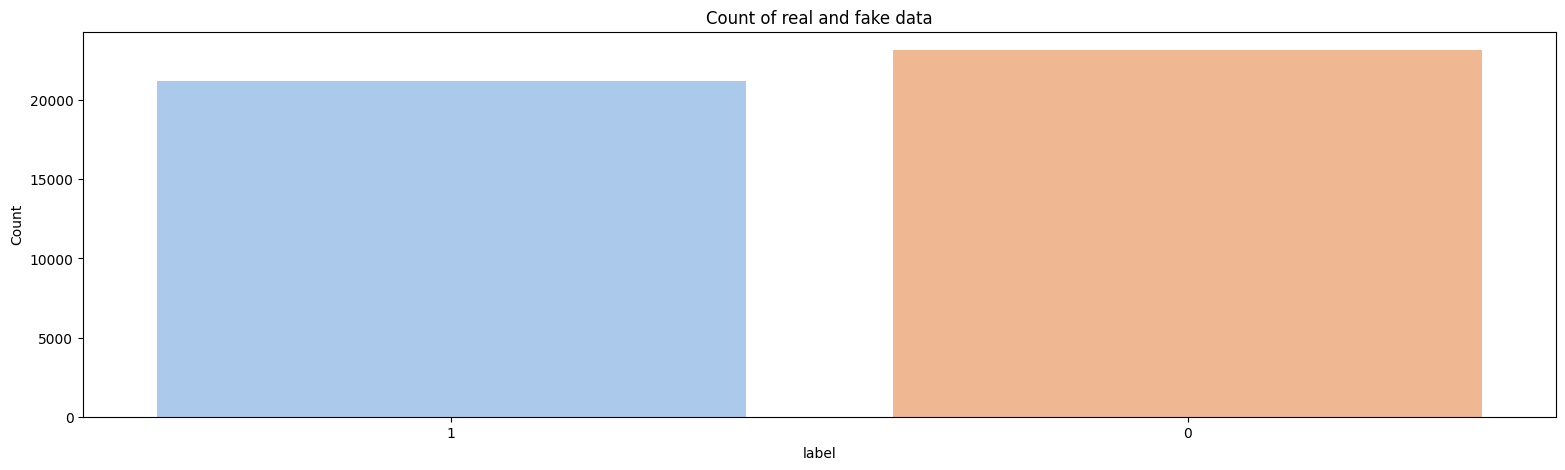

In [29]:
# Assuming data is a pandas dataframe with a column named "label"

print(clean_news_data_pd_df["label"].value_counts())


fig, ax = plt.subplots(1, figsize=(19, 5))
graph1 = sns.countplot(x=clean_news_data_pd_df.label,ax=ax,palette="pastel");
graph1.set_title("Count of real and fake data")
graph1.set_ylabel("Count")
graph1.set_xlabel("label")
plt.show()



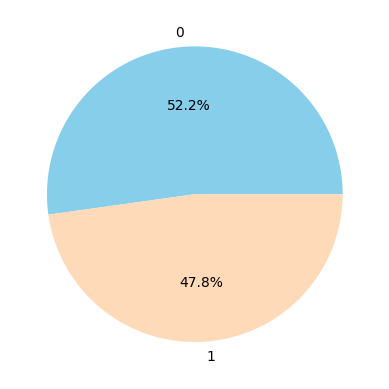

In [30]:
graph2 = plt.pie(clean_news_data_pd_df["label"].value_counts().values,explode=[0,0],labels=clean_news_data_pd_df.label.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [32]:
clean_news_data_pd_df['label']= le.fit_transform(clean_news_data_pd_df['label'])
clean_news_data_pd_df

,label,final_news
0,1,image sugest north korea agresive work balisti...
1,1,trump slap travel restriction nkorea venezuela...
2,1,clinton trump escalate fight dramatic wek nati...
3,0,hawai atorney general humiliates jef sesion wh...
4,0,trump diversity council member threatens quit ...
...,...,...
44846,1,apeal judge gril lawyer trump imigration orde...
44847,1,nearly half australian shrink prospect preside...
44848,1,trump dismay anger aly abandoning global clima...
44849,1,un cal iran resolve prisoner hunger strike gen...


In [33]:
#Use TfidfVectorizer to add weight to repeated words
Vectorizer = TfidfVectorizer(max_features=100)
X = Vectorizer.fit_transform(clean_news_data_pd_df['final_news']).toarray()
feature_names = Vectorizer.get_feature_names_out()

In [34]:
y = clean_news_data_pd_df[['label']]

In [35]:
y

,label
0,1
1,1
2,1
3,0
4,0
...,...
44846,1
44847,1
44848,1
44849,1


In [36]:
feature_names[:8000]

array(['acording', 'administration', 'also', 'america', 'american',
       'atack', 'back', 'bil', 'campaign', 'candidate', 'city', 'clinton',
       'could', 'country', 'court', 'day', 'democrat', 'democratic',
       'department', 'donald', 'election', 'even', 'federal', 'first',
       'foreign', 'former', 'get', 'go', 'going', 'government', 'group',
       'hilary', 'house', 'image', 'including', 'know', 'last', 'law',
       'leader', 'like', 'made', 'make', 'many', 'may', 'medium',
       'member', 'milion', 'military', 'month', 'national', 'ned', 'new',
       'news', 'north', 'obama', 'ofice', 'oficial', 'one', 'party',
       'people', 'percent', 'plan', 'police', 'policy', 'political',
       'president', 'presidential', 'public', 'report', 'republican',
       'reuters', 'right', 'rusia', 'said', 'say', 'security', 'senate',
       'since', 'state', 'statement', 'suport', 'take', 'tax', 'think',
       'time', 'told', 'trump', 'two', 'united', 'video', 'vote', 'want',
      

In [37]:
X

array([[0.        , 0.        , 0.03890957, ..., 0.        , 0.        ,
        0.04027343],
       [0.        , 0.22132333, 0.03004474, ..., 0.        , 0.02676232,
        0.        ],
       [0.        , 0.0411695 , 0.08383166, ..., 0.08266233, 0.02489099,
        0.        ],
       ...,
       [0.03771044, 0.15753185, 0.08019381, ..., 0.2767633 , 0.23810854,
        0.13834129],
       [0.        , 0.        , 0.29628978, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.11987815, 0.        ,
        0.08389023]])

In [38]:
X=pd.DataFrame(X, columns = feature_names)

In [39]:
X.shape

(44372, 100)

In [40]:
X

,acording,administration,also,america,american,atack,back,bil,campaign,candidate,...,vote,want,washington,way,wek,white,woman,world,would,year
0,0.000000,0.000000,0.038910,0.000000,0.000000,0.060322,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.047942,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.040273
1,0.000000,0.221323,0.030045,0.086701,0.074084,0.093157,0.000000,0.000000,0.039475,0.000000,...,0.0,0.000000,0.037019,0.000000,0.000000,0.116181,0.0,0.000000,0.026762,0.000000
2,0.000000,0.041170,0.083832,0.040319,0.034452,0.000000,0.000000,0.000000,0.073430,0.218104,...,0.0,0.072900,0.034431,0.036949,0.104937,0.072038,0.0,0.082662,0.024891,0.000000
3,0.000000,0.209476,0.142182,0.102574,0.000000,0.000000,0.094278,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.094000,0.088989,0.183270,0.0,0.000000,0.063324,0.000000
4,0.172819,0.000000,0.000000,0.000000,0.377585,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.079896,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.054560,0.190196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.283927,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
44368,0.000000,0.000000,0.000000,0.073906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.066814,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.136878,0.106035
44369,0.037710,0.157532,0.080194,0.077139,0.065914,0.000000,0.141799,0.043238,0.035122,0.000000,...,0.0,0.034868,0.032936,0.035345,0.000000,0.103368,0.0,0.276763,0.238109,0.138341
44370,0.000000,0.000000,0.296290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.123628,0.000000,0.0,0.000000,0.000000,0.000000


In [41]:
X= X.reset_index()

y= y.reset_index()

In [42]:
X_new = pd.concat([X,y],axis=1)

In [43]:
X_new

,index,acording,administration,also,america,american,atack,back,bil,campaign,...,washington,way,wek,white,woman,world,would,year,index,label
0,0,0.000000,0.000000,0.038910,0.000000,0.000000,0.060322,0.000000,0.000000,0.000000,...,0.047942,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.040273,0,1
1,1,0.000000,0.221323,0.030045,0.086701,0.074084,0.093157,0.000000,0.000000,0.039475,...,0.037019,0.000000,0.000000,0.116181,0.0,0.000000,0.026762,0.000000,1,1
2,2,0.000000,0.041170,0.083832,0.040319,0.034452,0.000000,0.000000,0.000000,0.073430,...,0.034431,0.036949,0.104937,0.072038,0.0,0.082662,0.024891,0.000000,2,1
3,3,0.000000,0.209476,0.142182,0.102574,0.000000,0.000000,0.094278,0.000000,0.000000,...,0.000000,0.094000,0.088989,0.183270,0.0,0.000000,0.063324,0.000000,3,0
4,4,0.172819,0.000000,0.000000,0.000000,0.377585,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.054560,0.190196,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44367,44367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.283927,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,44846,1
44368,44368,0.000000,0.000000,0.000000,0.073906,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.136878,0.106035,44847,1
44369,44369,0.037710,0.157532,0.080194,0.077139,0.065914,0.000000,0.141799,0.043238,0.035122,...,0.032936,0.035345,0.000000,0.103368,0.0,0.276763,0.238109,0.138341,44848,1
44370,44370,0.000000,0.000000,0.296290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.123628,0.000000,0.0,0.000000,0.000000,0.000000,44849,1


In [44]:
y=X_new['label']

In [45]:
y

0        1
1        1
2        1
3        0
4        0
        ..
44367    1
44368    1
44369    1
44370    1
44371    0
Name: label, Length: 44372, dtype: int64

In [46]:
X=X_new

In [47]:
X=X.drop(['index','label','index'],axis=1)

In [48]:
X

,acording,administration,also,america,american,atack,back,bil,campaign,candidate,...,vote,want,washington,way,wek,white,woman,world,would,year
0,0.000000,0.000000,0.038910,0.000000,0.000000,0.060322,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.047942,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.040273
1,0.000000,0.221323,0.030045,0.086701,0.074084,0.093157,0.000000,0.000000,0.039475,0.000000,...,0.0,0.000000,0.037019,0.000000,0.000000,0.116181,0.0,0.000000,0.026762,0.000000
2,0.000000,0.041170,0.083832,0.040319,0.034452,0.000000,0.000000,0.000000,0.073430,0.218104,...,0.0,0.072900,0.034431,0.036949,0.104937,0.072038,0.0,0.082662,0.024891,0.000000
3,0.000000,0.209476,0.142182,0.102574,0.000000,0.000000,0.094278,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.094000,0.088989,0.183270,0.0,0.000000,0.063324,0.000000
4,0.172819,0.000000,0.000000,0.000000,0.377585,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.079896,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.054560,0.190196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.283927,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
44368,0.000000,0.000000,0.000000,0.073906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.066814,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.136878,0.106035
44369,0.037710,0.157532,0.080194,0.077139,0.065914,0.000000,0.141799,0.043238,0.035122,0.000000,...,0.0,0.034868,0.032936,0.035345,0.000000,0.103368,0.0,0.276763,0.238109,0.138341
44370,0.000000,0.000000,0.296290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.123628,0.000000,0.0,0.000000,0.000000,0.000000


# Split the data into training and testing datasets by using train_test_split.

In [49]:
#Split Data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

# Create a Logistic Regression Model with the Original Data

In [50]:
#Creating Logisitc Regression

#Initiate Model
model = LogisticRegression(solver = 'lbfgs', random_state=1)

#Fit model using training Data
model.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [51]:
#Make Predictions
predictions = model.predict(X_test)
predictions

array([1, 1, 0, ..., 1, 1, 0])

In [52]:
#Evaluating Model Performance
print(balanced_accuracy_score(y_test, predictions))

0.9839309028627865


In [53]:
#Generate a confusion matrix for the model
cm = confusion_matrix(y_test, predictions)
cm

array([[5620,  104],
       [  75, 5294]])

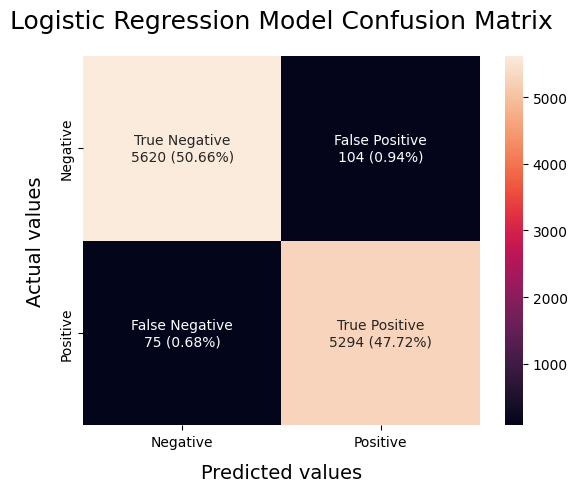

In [54]:
# Create heatmap
def makeCM_Matrix(cm_matrix, title):

  categories = ['Negative','Positive']

  group_names = ['True Negative','False Positive', 'False Negative','True Positive']

  group_percentages = ['{0:.2%}'.format(value) for value in cm_matrix.flatten() / np.sum(cm_matrix)]

  labels = [f'{v1}\n{v2} ({v3})' for v1, v2 ,v3 in zip(group_names,cm_matrix.flatten(),group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cm_matrix, annot = labels,fmt = '',
  xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title (f"{title} Confusion Matrix", fontdict = {'size':18}, pad = 20)
  plt.show()

makeCM_Matrix(cm_matrix=cm, title='Logistic Regression Model')

In [55]:
#Printing Classification Report for the model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5724
           1       0.98      0.99      0.98      5369

    accuracy                           0.98     11093
   macro avg       0.98      0.98      0.98     11093
weighted avg       0.98      0.98      0.98     11093



# Predict a Logistic Regression Model with Resampled Training Data

In [56]:
# Using RandomOverSampler to Resample Training Data
from imblearn.over_sampling import RandomOverSampler

#Assigning random_state parameter of 1 to the model
random_samp = RandomOverSampler(random_state = 1)

#Fitting Original training Data to the random_oversampler model
X_res, y_res = random_samp.fit_resample(X_train, y_train)

In [57]:
# Count the distinct values of the resampled labels data
y_res.value_counts()

1    17444
0    17444
Name: label, dtype: int64

In [58]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
res_model = LogisticRegression(solver='lbfgs', random_state=1)

# Fit the model using the resampled training data
res_model.fit(X_res, y_res)

# Make a prediction using the testing data
res_prediction = res_model.predict(X_test)
res_prediction

array([1, 1, 0, ..., 1, 1, 0])

In [59]:
print(balanced_accuracy_score(y_test, res_prediction))

0.9845012175520651


In [60]:
#Generate Confusion matrix fro the model
confusion = confusion_matrix(y_test, res_prediction)
confusion

array([[5618,  106],
       [  67, 5302]])

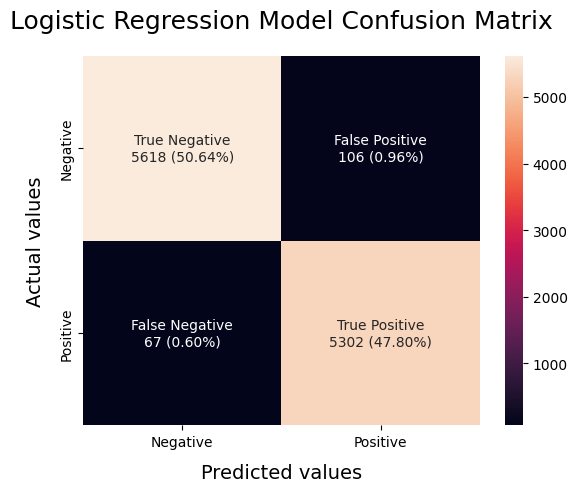

In [61]:
# Create heatmap
def makeCM_Matrix(cm_matrix, title):

  categories = ['Negative','Positive']

  group_names = ['True Negative','False Positive', 'False Negative','True Positive']

  group_percentages = ['{0:.2%}'.format(value) for value in cm_matrix.flatten() / np.sum(cm_matrix)]

  labels = [f'{v1}\n{v2} ({v3})' for v1, v2 ,v3 in zip(group_names,cm_matrix.flatten(),group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cm_matrix, annot = labels,fmt = '',
  xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title (f"{title} Confusion Matrix", fontdict = {'size':18}, pad = 20)
  plt.show()

makeCM_Matrix(cm_matrix=confusion, title='Logistic Regression Model')

In [62]:
print(classification_report(y_test, res_prediction ))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5724
           1       0.98      0.99      0.98      5369

    accuracy                           0.98     11093
   macro avg       0.98      0.98      0.98     11093
weighted avg       0.98      0.98      0.98     11093



# Deep Learning

In [63]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape


(33279, 100)

In [65]:
# Define the model.
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=X_train_scaled.shape[1]))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=30, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                8080      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 10541 (41.18 KB)
Trainable params: 10541 (41.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
nn.compile(loss="binary_crossentropy", optimizer= "adam", metrics=['accuracy'])

In [67]:
fit_model = nn.fit(X_train_scaled, y_train,epochs=100)

Epoch 1/100
1040/1040 [==============================] - 3s 2ms/step - loss: 0.0970 - accuracy: 0.9648
Epoch 2/100
1040/1040 [==============================] - 2s 2ms/step - loss: 0.0287 - accuracy: 0.9914
Epoch 3/100
1040/1040 [==============================] - 3s 3ms/step - loss: 0.0192 - accuracy: 0.9946
Epoch 4/100
1040/1040 [==============================] - 3s 3ms/step - loss: 0.0150 - accuracy: 0.9954
Epoch 5/100
1040/1040 [==============================] - 2s 2ms/step - loss: 0.0095 - accuracy: 0.9973
Epoch 6/100
1040/1040 [==============================] - 2s 2ms/step - loss: 0.0071 - accuracy: 0.9980
Epoch 7/100
1040/1040 [==============================] - 2s 2ms/step - loss: 0.0067 - accuracy: 0.9978
Epoch 8/100
1040/1040 [==============================] - 2s 2ms/step - loss: 0.0040 - accuracy: 0.9988
Epoch 9/100
1040/1040 [==============================] - 2s 2ms/step - loss: 0.0046 - accuracy: 0.9986
Epoch 10/100
1040/1040 [==============================] - 4s 4ms/step - l

# Analysis After Training

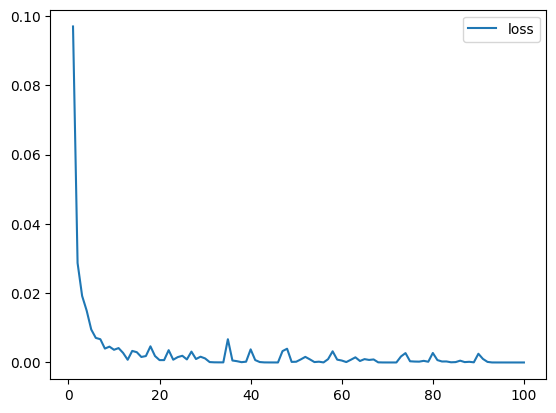

In [68]:
 # Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

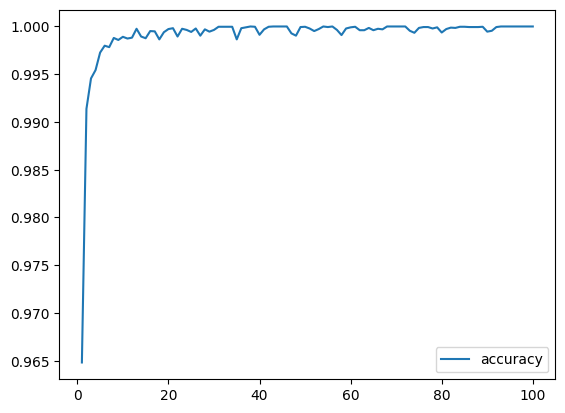

In [69]:
 # Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [70]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

347/347 - 1s - loss: 0.0585 - accuracy: 0.9959 - 629ms/epoch - 2ms/step
Loss: 0.058488547801971436, Accuracy: 0.9958532452583313


In [71]:
nn.save('Models/NewsPredictionmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model prediction

In [72]:
#Save and Load a machine learning model
import pickle

# Save the model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
